# **Illustrating the gradient leakage problem**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from multiprocessing import Lock

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2024-01-30 18:21:26.979926: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-30 18:21:26.979952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-30 18:21:27.008041: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-30 18:21:27.066740: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-30 18:21:27.927976: W tensorflow/compiler/tf2

In [3]:
NUM_GPUS = 4
GPU_MEM_SIZE = 1536 #MiB

In [4]:
#prepare the GPU (for supporting possible multiprocessing)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=GPU_MEM_SIZE)]*NUM_GPUS)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPU, 4 Logical GPUs


2024-01-30 18:21:30.042435: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-30 18:21:30.151679: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-30 18:21:30.151839: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
RESULTS_ROOT = "../01_simulation/04_results/"
SEEDS = ['42', '1234', '1867', '613', '1001']
VEHICLE = "h3408c1:0"
#VEHICLE = "h482c1:0"
#VEHICLE = "h3120c1:0"
#VEHICLE = "h73c1:0"
#VEHICLE = "carIn106:4"
TIME_WINDOW = 15*60 #seconds

In [6]:
tf.config.list_logical_devices('GPU')[0].name

'/device:GPU:0'

In [7]:
global_model_lock = Lock() # handles access to the global model
with tf.device(tf.config.list_logical_devices('GPU')[0].name):
    global_model = tf.keras.models.load_model("saved_models/pretrained")

In [22]:
p_data = pd.DataFrame()
#READING DATA:
for s in SEEDS:
    filename = RESULTS_ROOT+f'poccup_by_vehs_{s}.csv'
    pf = pd.read_csv(filename)
    pf["seed"] = [s]*len(pf)
    p_data = pd.concat([p_data, pf])
    
parkings = p_data["parking_id"].unique()
true_parkings = p_data[p_data["veh_id"] == VEHICLE]["parking_id"].unique()
    
#transforming data for learning:
p_data = pd.get_dummies(p_data, columns=["parking_id"])
p_data["time"] = p_data["time"] - 4*24*60*60
p_data["time"] = p_data["time"].astype(int)
p_data["time_of_day"] = (p_data["time"] - (p_data["time"] // (24*60*60))*24*60*60) / (24*60*60) #converting to 0.0-1.0 and removing periodicity

#data for plotting:
bins = np.arange(0, 1, 1/(24*6))
hist, bin_edges = np.histogram(p_data[p_data["veh_id"] == VEHICLE]["time_of_day"], bins=bins)

In [9]:
with tf.device(tf.config.list_logical_devices('GPU')[1].name):
    vehicle_model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])

    vehicle_model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(0.001))
    vehicle_model.build(input_shape=(None,79))

In [10]:
with tf.device(tf.config.list_logical_devices('GPU')[1].name):
    vehicle_model.set_weights(global_model.get_weights())

In [11]:
p_train = p_data[p_data["veh_id"] == VEHICLE]
X_train = p_train.drop(columns=["veh_id", "time", "occupancy", "seed"])
y_train = p_train["occupancy"]

In [12]:
with tf.device(tf.config.list_logical_devices('GPU')[1].name):
    history = vehicle_model.fit(x=X_train, y=y_train, epochs=1, batch_size=10000)

2024-01-30 18:21:52.532010: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-30 18:21:52.856726: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa61d5e4190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-30 18:21:52.856772: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-01-30 18:21:52.863187: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-30 18:21:52.880678: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1706635312.951798   48752 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 1s 1s/step - loss: 0.0020


In [13]:
def create_test_data(p_id, p_data):
    '''
        Creates test data for parking data for a complete day.
    '''
    parking_data = p_data[p_data[f"parking_id_{p_id}"] == 1]
    t = np.arange(0, 1, 1/(24*60*60))
    one_hot = parking_data.drop(columns=["veh_id", "time", "occupancy", "seed", "time_of_day"]).iloc[0]
    one_hot = [one_hot.values]*len(t)
    pred_x = np.array(one_hot)
    pred_x = pd.DataFrame(pred_x)
    pred_x["t"] = t
    return pred_x

In [14]:
def create_difference_dataset(p_data, parkings, vehicle_model, vehicle_gpu, global_model, global_gpu, global_model_lock):
    '''
        Creates a per parking list of the differences in prediction between the global and
        a vehicle's model.
        
        Parameters:
            - p_data: parking lot dataset
            - parkings: list of parking lots
            - vehicle_model: tensorflow model of the vehicle
            - vehicle_gpu: logical device on which the vehicle model resides
            - global_model: tensorflow model of the global model
            - global_gpu: logical device on which the global model resides
            - global_model_lock: lock object to access the global model
            
        Returns:
            - prediction differences
    '''
    p_diffs = {}

    for p in parkings:
        test_data = create_test_data(p, p_data)
        #local, vehicle:
        with tf.device(vehicle_gpu):
            pred_vehicle = vehicle_model.predict(test_data, batch_size=10000)
            
        #global:
        global_model_lock.acquire()
        with tf.device(global_gpu):
            pred_global  = global_model.predict(test_data, batch_size=10000)
        global_model_lock.release()
        
        p_diffs[p] = (pred_vehicle-pred_global)**2
        
    return p_diffs

p_diffs = create_difference_dataset(p_data, parkings,
                                    vehicle_model, tf.config.list_logical_devices('GPU')[1].name,
                                    global_model, tf.config.list_logical_devices('GPU')[0].name,
                                    global_model_lock)

9/9 [==============================] - 0s 3ms/step


In [15]:
def predict_eval_positions(p_diffs, true_parkings, num_parking_lots = 10):
    '''
        Maliciously infers possibly visited parking lots from
        prediction differences. Then evaluates the success rate of the attacker.
        
        Parameters:
            - p_diffs: prediction differences
            - true_parkings: list of the parking lots which were visited by a vehicle
            - num_parking_lots: how many lots try to guess
            
        Returns:
            - the successfully identified parking lots (out of the prescribed num_parking_lots)
    '''
    
    p_diff_means = {}
    for p in parkings:
        p_diff_means[p] = np.mean(p_diffs[p])

    p_diff_series = pd.Series(p_diff_means)

    #converting to sets to be able to get the prediction as an intersection
    predicted_ps = set(p_diff_series.nlargest(num_parking_lots).index)
    true_parkings = set(true_parkings)
    intersection = predicted_ps.intersection(true_parkings)
    return intersection

pred_lots = predict_eval_positions(p_diffs, true_parkings)

print(pred_lots, len(pred_lots))

{'pa55', 'pa-43', 'pa-27', 'pa-55', 'pa-71', 'pa43', 'pa-144', 'pa11'} 8


In [16]:
def search_nearest_move_bin_(pred_time, move_bins_bins, move_bins_counts):
    '''
        From a moving time histogram and a prediction time, it calculates the
        offset between a true moving time and the prediction time.
        
        Parameters:
            - pred_time: predicted moving time in [0,1) range
            - move_bins_bins: x values of the histogram (bin ranges)
            - move_bins_counts: y values of the histogram
            
        Returns:
            - an offset, if negative: the predicted value is later than the closest true moving
    '''
    
    ref_idx, = np.where(move_bins_bins == pred_time)[0]
    rel_idx = 0
    #searching backward:
    while (ref_idx+rel_idx >= 0) and (move_bins_counts[ref_idx+rel_idx]==0):
        rel_idx -= 1
    down_step = 1
    if rel_idx<=0: #found some data
        down_step = rel_idx
    rel_idx = 0
    #searching forward:
    while (ref_idx+rel_idx < len(move_bins_counts)) and (move_bins_counts[ref_idx+rel_idx]==0):
        rel_idx += 1
    if rel_idx < (24*60*60)//TIME_WINDOW: #found some data
        if down_step == 1:
            return rel_idx
        else:
            return down_step if abs(down_step)<rel_idx else rel_idx
    else:
        return None if down_step == 1 else down_step

def predict_eval_time(p_diffs, true_moving_times, time_window=900):
    '''
        Maliciously infers possible moving time from
        prediction differences. Then evalutes how many time windows
        the prediction is away from a true moving of the vehicle.
        
        Parameters:
            - p_diffs: prediction_differences
            - true_moving_times: data series describing the true moving times
            - time_window: how long is a time window in seconds
            
        Returns:
            - an offset, how many time window is away the best prediction from
              a true moving of the vehicle
    '''
    
    time_diffs = {}
    for p in parkings:
        for t in range(0, 24*60*60, time_window):
            if t in time_diffs:
                time_diffs[t] += np.mean(p_diffs[p][t:t+time_window])
            else:
                time_diffs[t] = np.mean(p_diffs[p][t:t+time_window])
    
    time_diffs_series = pd.Series(time_diffs) #to be able to run handy functions
    
    prediction_diff_rates_x = np.arange(time_window, 24*60*60, time_window) #1 step shorter because of the differentiation
    prediction_diff_rates_y = np.abs(np.diff(time_diffs_series.values)) #|d/dt(time_diff(x, t))|
    prediction_diff_rates = pd.Series(data = prediction_diff_rates_y, index = prediction_diff_rates_x)
    pred_time = prediction_diff_rates.index[prediction_diff_rates.argmax()]/(24*60*60)
    #creating the histogram:
    move_bins_counts, move_bins_bins = np.histogram(true_moving_times, bins=np.arange(0, 24*60*60, time_window)/(24*60*60))
    #calculating the offset:
    offset = search_nearest_move_bin_(pred_time, move_bins_bins, move_bins_counts)
    return offset

In [17]:
predict_eval_time(p_diffs, p_train["time_of_day"])

0

In [18]:
time_diffs = {}
for p in parkings:
    for t in range(0, 24*60*60, TIME_WINDOW):
        if t in time_diffs:
            time_diffs[t] += np.mean(p_diffs[p][t:t+TIME_WINDOW])
        else:
            time_diffs[t] = np.mean(p_diffs[p][t:t+TIME_WINDOW])

In [19]:
time_diffs_series = pd.Series(time_diffs)

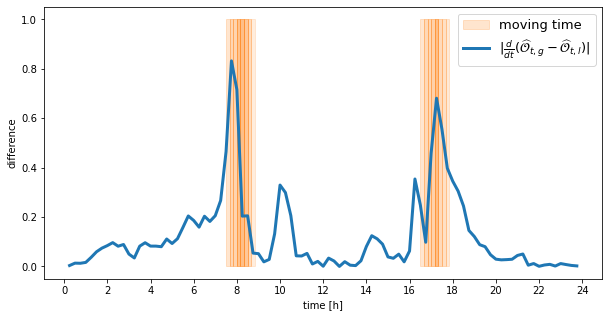

In [44]:
MIN_ALPHA = 0.1
MAX_ALPHA = 0.5

color_min = min(hist)
color_max = max(hist)
has_legend = False
plt.figure(figsize=(10,5))
for i in range(len(bins)-1):
    if hist[i]>0:
        label = "moving time" if not(has_legend) else ""
        has_legend = True

        plt.fill_between(x=[i*1/6, (i+1)*1/6], y1=0, y2=1.0,
                         alpha=(hist[i]-color_min)/(color_max-color_min)*(MAX_ALPHA-MIN_ALPHA)+MIN_ALPHA,
                         color="tab:orange",
                         label=label)

plot_res_x = np.arange(TIME_WINDOW, 24*60*60, TIME_WINDOW)
plot_res_y = np.abs(np.diff(time_diffs_series.values))
plot_res = pd.Series(data=plot_res_y, index=plot_res_x)


plt.plot(plot_res_x/(60*60), plot_res_y,
         linewidth=3.0,
         label="$|\\frac{d}{dt}(\\widehat{\\mathcal{O}}_{t,g}-\\widehat{\\mathcal{O}}_{t,l})|$")
plt.xticks(ticks=np.arange(0, 26, 2));
plt.xlabel("time [h]")
plt.ylabel("difference")
plt.legend(fontsize=13)

In [21]:
#print(f'{time_diffs_series.index[time_diffs_series.argmax()]//(60*60):2d}:{time_diffs_series.index[time_diffs_series.argmax()]%(60*60)//60:02d}')
print(f'{plot_res.index[plot_res.argmax()]//(60*60):2d}:{plot_res.index[plot_res.argmax()]%(60*60)//60:02d}')

 8:15


In [22]:
pred_time = plot_res.index[plot_res.argmax()]/(24*60*60)
pred_time

0.34375

In [23]:
move_bins_counts, move_bins_bins = np.histogram(p_train["time_of_day"], bins=np.arange(0, 24*60*60, TIME_WINDOW)/(24*60*60))

In [25]:
search_nearest_move_bin(pred_time, move_bins_counts, move_bins_bins)

0